# An Zero-order Function Optimizer Based on Trust Region Policy Optimization
This is an introduction to the idea behind this project. Optimization research community has various algorithms on different order of problem. Here, zero order means we only have access to the function value itself (either we know the analytical function or we have the program to compute function value at any given point). The optimzer will have no information on gradient nor hessian matrix. There are many other zero order algorithms like evolution algorithm but in this project, for the first time, we applied reinforcement learning technique in zero order optimization problem. I am not intent to design a competitive algorithm to beat the classic evolution algorithm, rather, I would like to show that the principle of reinfocement learning is quite effective when we only have limited knowledge of environment (rather than its whole structure). Hence, it is a promising alternative for zero order optimization algorithm.

We implemented a policy network trained by TRPO. Our TRPO is improved by using prioritized experience as train data compared to the convetional monte carlo simulated data. We will show why this is important and efficient when we want our TRPO algorithm getting rid of local minimum.

## The origin
The idea came from my classmate in civil engineering. He had some building structure optimization problem in which several variable could be adjusted while the total cost should be minimized. There was no analytical function available for the total cost but only an external C++ program computing it. Hence this was an zero-order optimization problem. Their solution was using some classic zero-order algorithms, however, they all had some disadvantages in different aspects. He discussed with me the possibility to start from the very basic random-walk algorithm and gradually improve the random brain to be a well trained agent. It reminded me the principle of reinforcement learning and then I decided to use policy optimization to solve this problem. I tried several policy optimization algorithm, including vanilla policy gradient, actor-crtic, deterministic policy gradient. Finally I found out that trust region policy optimization (TRPO) is the best one.

I will describe how to apply TRPO in this problem together with some explanation of my python program. For more detailed academic refernce to TRPO, please refer to [John Schulman's thesis](http://joschu.net/docs/thesis.pdf).

## The problem
We will more formally define the problem here.

### Given a function f(x), the goal is finding its global minimum inside a certain area. 

The function value at any given point should be provided by external program. This can be achieved by using either analytical expression or other methods to perform calculation. The external program should also limit the variable x inside the defined area. We limit our optmization problem at zero order. This means we use the function value as our only available information even if we know the analytical expression. No gradient or hessian matrix or other higher order information will be feeded into our algorithm.

## Random Walk
The very basic algorithm coming to one's mind is the random walk. The algorithm could be described as follows:
```
Start from point X, maximum number of iteration of searching S, maximum path length L, step count i, global minimum record a
a = X
Repeat S times:
  i = 0, x = X
  while i < L:
    while true:
      generate a random step d
      if f(x + d) < f(x):
        x = x + d
        i = i + 1
        break
  if f(a) > f(x):
    a = x
return a
```
Imagine a drunken guy trying to find global minimum. Each time he starts from point X. He tries to randomly pick a step d. If he finds out the new position has smaller function value, he will move to the new position. Otherwise he stays at the old position and tries to pick another random step. We will allow the drunken guy to move at most L steps in one round then order him to start from X again to begin a new round. We will treat the best of his final position in each round as the global minimum.

As you may see, the random walk algorithm could be rather inefficient simply because the guy is drunken. He actually always randomly picks up his step d. All the experience he got was obsoleted and he will never learn anything from previous experience.

Therefore, I propose to use a trained agent to replace the random drunken guy. We will use a policy network to propose the step at any given point and the policy will be trained by reinforcement learning.

## Improve Random Walk with Policy Opmization
To improve the random walk algorithm, we only need to add one thing. After randomly generate the path, we use that path to train our agent. In this project, our agent would be a neural network that can propose which step to take at any given point. Our goal is after training, the network will converge and for any given point, propose a step leading to the global minimum. In reinforcement learning, this kind of method is callng policy optimization. The whole algorithm could be described as below:
```
Start from point X, maximum number of iteration of searching S, maximum path length L, step count i
Initiate step propose policy network
Repeat S times:
  i = 0, x_0 = X, initiate rewards r_i as empty
  while i < L:
    using policy network to generate a random step d
    x_i+1 = x_i + d
    r_i = f(x_i) - f(x_i+1)
    i = i + 1
    break
  record (x_0, x_1, ... , x_L) as a path, process disconted rewards based on r_i and discount factor gamma
  using processed data to train policy network
After training is converged, using policy network to collect one path (x_0, x_1, ... , x_L)
return x_L
```
As you may see, the main difference compared to random walk is we use generated path to train policy network. This is a natural idea to improve the totally random agent. As for the specific training algorithm, I tried several ones include vanilla policy gradient, actor-critic, deterministic policy gradient, etc. Finally I find out that trust region policy optimization is a very capable algorithm to train our step proposal policy network. If you are not familiar with TRPO, it is best to read [John Schulman's thesis](http://joschu.net/docs/thesis.pdf) first. I will assume the reader is familiar with TRPO and describe details that how TRPO is used in this project.
## Details of Implementation
### Step Proposal Policy Network
The agent, or in other word, the brain of this algorithm, is a step proposal policy network. It is a multi-layer fully connected neural network that takes the current position coordinate as input and outputs two parameters: the mean and standard deviation that defines a normal distribution. Then from a parameterized normal distribution, we sample a vector serving as the step that the agent should take to move to the new position. In this way, the agent start from starting point and take L steps to get to a destination. We use this destination as its final prediction of global minimum. The neural network is shown in the picture below:![Image of Yaktocat](https://github.com/ssw5075839/TRPO/blob/master/neural%20network.PNG?raw=true)

Agent will be rewarded at each step with amount equal to f(old_position) - f(new_position). This reflects the fact that we encourage agent going to the global minimum and the smaller the function value at new poition, the greater the reward will be. We also set the discounted factor gamma to be 0. This is very different from many reinforcement learning problem since this will encourage agent to be greedy, namely, trying to find out global minimum as soon as possible. Greedy behavior may leading the agent converging to a sub-optimal solution, however, it is not a concern in this problem. This is simply beacuse there is no constraint on each step: agent could take what ever step at any given point. So a greedy decision history will not impose any punishment in the future. Plus a greedy behavior could encourage agent to find out the global minimum much faster and save our computation time.

When the policy network is well trained, the output standard deviation should be small at any given point. That means the agent is very sure that where the global minimum is. No matter where it is, just follow the mean of normal distribution and with very high confidence (namely, very small standard deviation), it should be the global minimum.
### Define Function in Env_example.py
The function to be optimized can be defined in Env_example.py as f(x). Please note that when you write your own function or call external program, it must support vector computation as we need to parallely collect many paths data at the same time. In my example, I use Michalewicz function. It is an artificial function with many local minimum and only one global minimum, usually used for optimization algorithm testing purpose. A two dimensional version is used in this project. Details of this function can be found [here](http://infinity77.net/global_optimization/test_functions_nd_M.html#go_benchmark.Michalewicz).
### Father Process in main.py
Main.py is the main program that will read all the option parameters, construct all the worker objects and execute worker.work() on different processes. The multi-process design is based on python's multiprocessing package. The main.py will check all the available CUDA devices on machine and assign one CUDA device to one child process. Each child process then will be executed and collect final predicted global minimum. Results from different child processes will be compared to pick the best one.

It should be noted that random seed has impact on the training results therefore each worker object will be assaigned with different seed. User could either input his own choice of seeds or simply use default seeds. Also ensemble of different seeds' results will improve overall global minimum prediction results.
### Design with CUDA
In fact, to effectively train the policy network, we can never use only one path. A batch of paths up to certain size is required. Actually we will show later that batch size plays a much more important role in this project.

To effectively collect enough paths, we must parallelly run the policy network. Therefore, CUDA is an ideal platform to perform this task. CUDA will also boost backpass speed when we train the policy network with large batch size data. Actually I tried to run my code on Intel's CPU and it proved to be rather slow. Therefore I will only support CUDA in this project. Also since we will need to train multiple agents to ensure best results, a multi-gpu machine will benefit more from my multi-process CUDA design.

In worker.py, a Worker class is defined. When the main.py is executed, several objects of Worker class will be created. Each Worker's work() method will be run on a child process with a CUDA device. The total number of child processes depends on the availabilities of CUDA devices.

The core of Worker class is the work() method, which basically implement the idea descibed in the psudeo codes above. After initialize policy network parameter with update_local_ops(), it will run train() method by max_global_iters times. After the standard deviation of policy network falling below tolerance, it stops training loop and start to make final prediction. Each Worker will put their results in a queue and the main.py will compare all of their results to present the final result.

In Worker's train() method, a TRPO algorithm is implemented. 

First, it will use obtain_samples() method to parallely collect paths that will be used to train policy network. With powerful Nvidia's GPU (mine is GTX 1080 8GB), it runs 20 times faster than Intel's CPU.

Then, it will process the raw path data. This involves prioritized experience sampling and data process (experience.sample() and process_samples() method). I will describe prioritized experience sampling in later part. As for now, you can just think it is the same as vanilla TRPO.

Finally, using processed data to train our policy network. As described in [John Schulman's thesis](http://joschu.net/docs/thesis.pdf), I implement the conjugate gradient algorithm (optimize_policy() method) in tensorflow. I have to give my many thanks to openAI's rllab, in which TRPO is implemented in Theano. Although I am not an expert on theano, it gives me a great reference when I implement such a complicated algorithm in tensorflow.

All in all, tensorflow is a flexibile framework and it gives me great freedom to implement any mathematic expression in CUDA. It also let me parallely sampling paths data. Depending on the tolerance setting, the total running time with 4 different seeds should be around 15 minutes for one CUDA device.
## Illustration of Random Walk and Trained Policy Network
To illustrate what our algorithm acutally does, I put on this graph with comparision between random walk agent and a well trained policy netwrok. We use a simple parabolic funtion as example. 

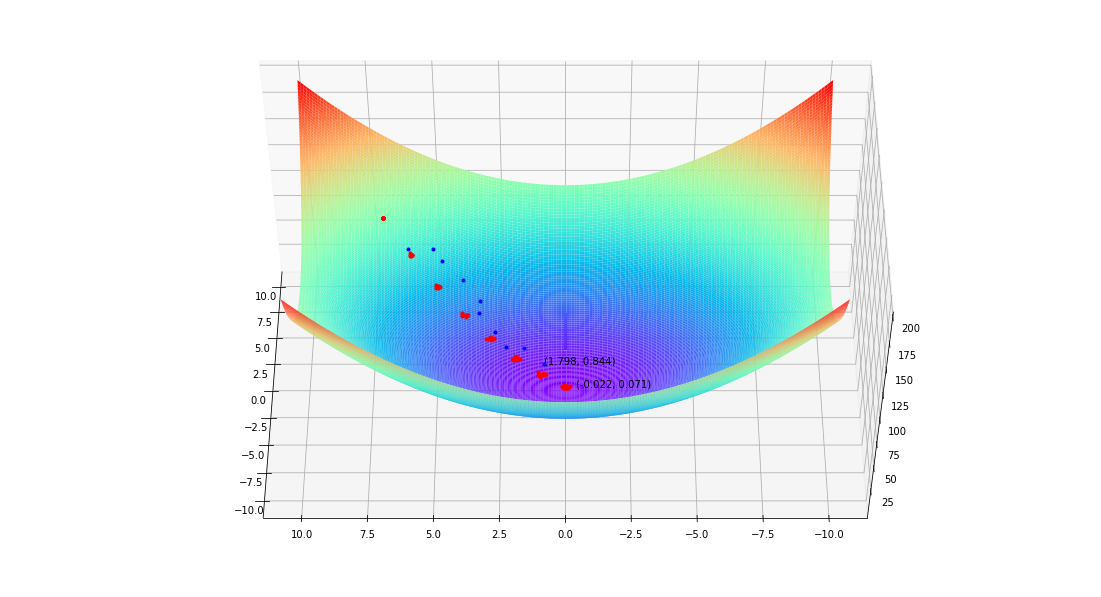

As you can see, with the same number step 10, a random walk agent (blue) started at (7.0,7.0) and ended at (1.798,0.844). Note that although only L steps are ploted here, actually thousands steps have been tried because many trials leading to worse results have been obsoleted.

On the other hand, a trained policy network (red) started at (7.0,7.0) and ends at (-0.022,0.071). This is very close to the true global minimum (0,0). I will explain how the policy network is trained.
## Trust Region Policy Optimization
I will breifly describe TRPO here in case you don't want to read the thesis. This will not include rigorous mathematical proof but rather a intuitive explanation.

The basic idea is optimize the policy network from the existing one. To be more conservative, we will limit the change from old policy netwrok to the new one staying within a defined range. The change of the policy network may sounds weird but since our policy network actually outputs the mean and standard deviation of normal distribution, it can be measured. This measurment is called KL-divergence. By limit the KL-divergence between the old and new distribution less than a small amount, we can guarantee that our newly searched policy network will differ from the old one by only a small amount.

With this limitation, we search our best new policy network in a small parameter manifold. The objective function is defined by expectation of likelihood ratio between the old and new distribution weighted by advantage over data collected from each path. To solve this special constrainted optimization problem, we need to compute a special gradient descent direction. This is different from vanilla gradient descent of the objective function because KL-divergence constraint is imposed. For the details please refer to the thesis.

We can now calculate the new policy network parameters: simply old policy network parameters plus the gradient. Then the whole algorithm rolls into another turn.
## The Problem of TRPO
TRPO sounds a perfect policy optimization algorithm with one main drawback: the number of monte carlo simlated paths need to be large enough to ensure that when we optimize each policy network, it explores enough space of our function's structure. Because this kind of exporation is sampling based, as no computer could detect every corner in a continuous space, it may overlook some important point when function has many local minima.

In fact, when opening area of the global minimum is much smaller than other local minimum, any sampling-based algorithm may have trouble simply because its collected traning data have very low probability covering this rare yet important area. Without this area included in training data, we can expect that agent will not know coming to the global minimum at all. This will be illustrated in the example of Michalewicz function. In this demonstration, I used two dimensions of it:
\begin{align}f(x_1, x_2)=-sin(x_1)\,sin^{20}(\frac{4x^2_1}{\pi})-sin(x_2)\,sin^{20}(\frac{5x^2_2}{\pi})\end{align}

Populating the interactive namespace from numpy and matplotlib


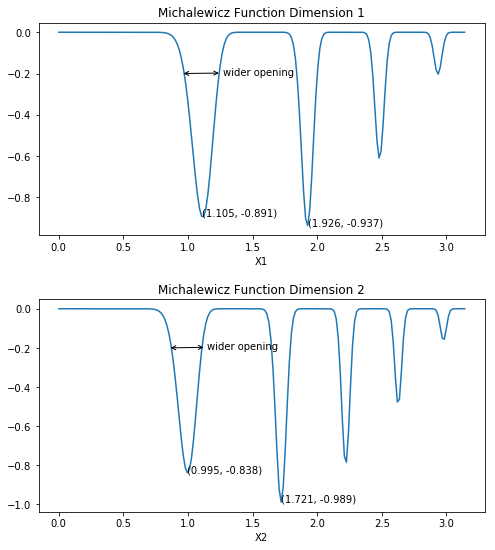

Each dimension in Michalewicz function is actually independent. So we can easily find global minimum for each dimension. The global minimum of first dimension is around 1.926 with a local minimum around 1.11 nearby. The global minimum of second dimension is around 1.721 with a local minimum around 0.97 nearby. As you can see, the opening area of the valley around local minimum is much larger than global minimum. This means during monte carlo sampling, it also has much higher probability to be sampled. 

Although TRPO works great in simple scenario like parabolic function, it fails here. From experiment, I found that a vanilla TRPO agent will always converge to (1.11, 0.97). This can be done by passing --vanilla 0 into the main.py. My explenation here is because it is much more probable to get sample in the valley centered at (1.11, 0.97) than (1.92, 1.72), therefore the agent will tend to go to the place where it thinks it can get the maximum reward. Hence a vanilla TRPO is easy to be fooled by wide opening of local minimum (high probability to get very good reward) and failed to find true global minimum (low probability to get best reward).

Further investigation of the objective funtion of TRPO could make this point clearer. The objective function is:

\begin{align}\underset{\theta}{maximize}\, \mathbb{E}_{s\sim \rho _{\theta _{old}},\,a \sim \pi_{\theta _{old}}(a\,|\,s)}\, \begin{bmatrix} \frac{\pi_{\theta}\,(a\,|\,s)}{\pi_{\theta _{old}}(a\,|\,s)}Q_{\theta _{old}}(s, \, a) \end{bmatrix}\end{align}

The ideal objective function should calculate expectation, however, in reality monte carlo simulation is performed in stead. Both the state s and action a should be sampled from the old policy network. However, as we discussed above, it is hard to sample the action a that lead state s into global minimum valley. Unless monte carlo sampling size is really big enough, this kind of data will not have enough ratio in training dataset. Without even enough knowledge about the global minimum, how can our agent know to get to it? The picture below shows what actually agent 'sees':

Populating the interactive namespace from numpy and matplotlib


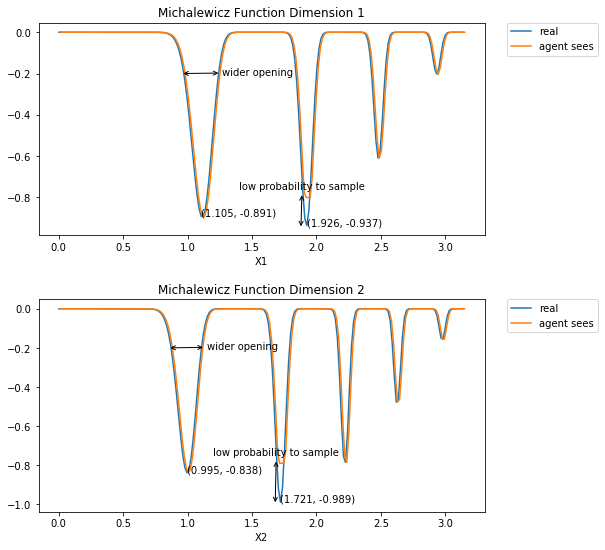

This effect exists in every monte carlo based algorithm, known as variance and sampling size trade off. The picture below shows this effect in a more exaggerated way:

Populating the interactive namespace from numpy and matplotlib


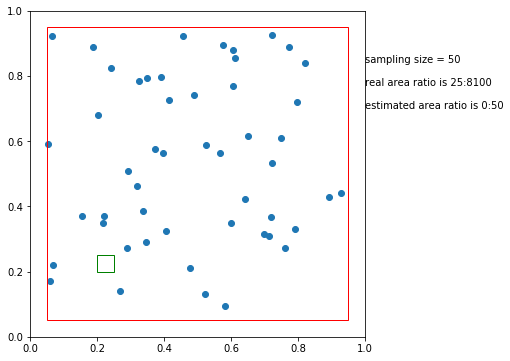

The graph below shows what agent learns versus number of iteration. We plot agent's prediction every 10 iterations and you can see that a vanilla TRPO agent will finally converge to (1.11, 0.99). However, the real global minimum is (1.93, 1.72)

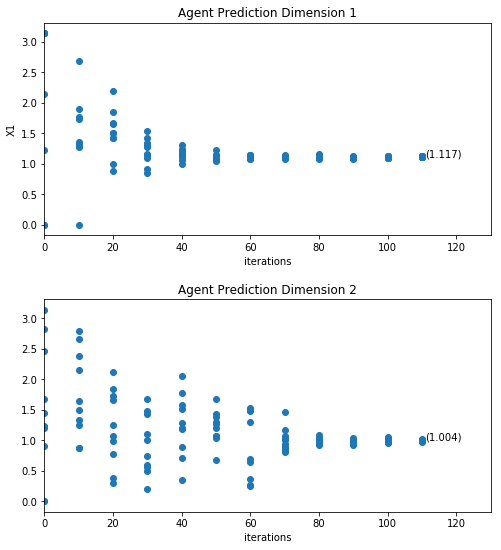

## Get Rid of Local Minimum by Prioritized Experience
As discussed above, since the 'opening' area of global minimum is so small, it is difficult to collect enough number of samples when total monte carlo sampling size is small. A large sampling size may be a possible solution thanks to the parallel scheme and CUDA. However, if the training data size is too big, network training computation cost will be impractically high. A natural idea will be prioritized resample of the large data set.

It is true that an agent needs both positive and negative data. A greatly rewarded path will tell the agent to follow it more often while a barely rewarded path will tell the agent to avoid it. However, too many barely rewarded paths are totally waste of computation resources. Our agent doesn't need that many nunber of negative data to learn avoiding it. Therefore, increasing the percentage of large reward path while maintain the total training data size unchaged sounds a good choice.

The details of prioritized experience replay can be found [here](https://arxiv.org/abs/1511.05952). The original work is for Q-learning. In TRPO, similar idea could be applied as well. Here, each path's priority should be based on its final position function value. The smaller it is, the higher priority it has. We only need to pay attention to one thing. Recall the TRPO objective function:

\begin{align}\underset{\theta}{maximize}\, \mathbb{E}_{s\sim \rho _{\theta _{old}},\,a \sim \pi_{\theta _{old}}(a\,|\,s)}\, \begin{bmatrix} \frac{\pi_{\theta}\,(a\,|\,s)}{\pi_{\theta _{old}}(a\,|\,s)}Q_{\theta _{old}}(s, \, a) \end{bmatrix}\end{align}

Since both s and a should be sampled from $\pi_{\theta _{old}}$, after we prioritized resampled our path data, we have to compensate each data with a importance sampling weight to guarantee the underlying distribution is unchanged. The original paper used bias annealing method, which only fully compensates for the non-uniform probabilities of sampling near convergence at the end of training. We will use the similar technique here, with a tanh style schedule of beta instead of a linear one. It should be noted here that without compensating for the non-uniform probabilities of sampling, agent may not converge at all. 

Complete TRPO with prioritized experience is as follows:

```
starting point X
maximum number of iteration of searching S
maximum path length L
step count i
batch size k
over sampling ratio r

Initiate step proposal policy network
Repeat S times:
  i = 0, x_0 = X
  initiate rewards r_i as empty,with over sampled batch size r*k
  while i < L:
    using policy network to generate a random step d
    x_i+1 = x_i + d
    r_i = f(x_i) - f(x_i+1)
    i = i + 1
  record all the (x_0, x_1, ... , x_L) as a batch of paths with size r*k
  prioritized sampling k out of r*k paths as training data
  priority is based on -f(x_L)
  process disconted rewards
  compensate each sampled data with importance-sampling weights beta
  perform TRPO training to policy network with processed data:
    calculate gradient g of TRPO loss function using tensorflow
    calculate the Fisher matrix A from KL divergence with tensorflow
    calculate s = A^-1 * g by conjugate gradient algorithm with symbolic A * g from tensorflow
    calculate initial line search step sqrt(2*kl_limit/(s^T * A * s))
    perform a line search with descent direction s to ensure KL divergence staying below limit
    update parameters according to the line search result

After training is converged, using policy network to collect one path (x_0, x_1, ... , x_L)

return x_L
```
## Illustration the Difference between Vanilla TRPO and TRPO with Prioritized Experience
Below we will show different scenarios. The first is a simple parabolic function $f(x) = x_0^2 + x_1^2$. The parabolic function surface is simple and we can expect vanilla TRPO algorithm will easily find the global minimum. This graph shows the convergence of vanilla TRPO:

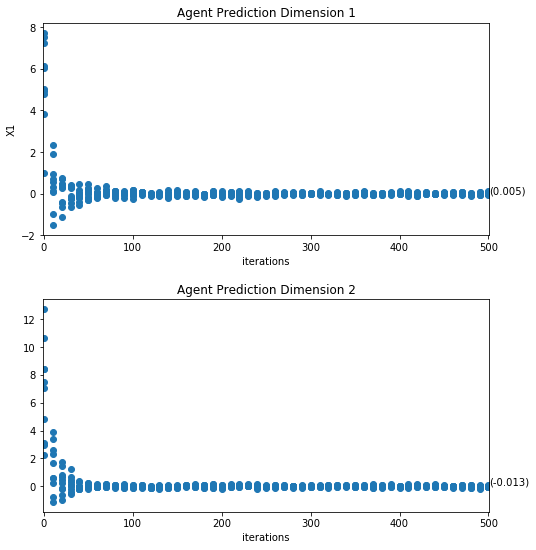

This graph shows the parabolic function and how agent moves after it is well trained.

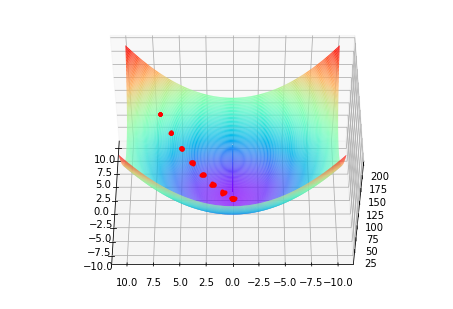

Of course, TRPO with prioritized experience could also solve this problem easily. This graph shows the convergence of TRPO with prioritized experience:

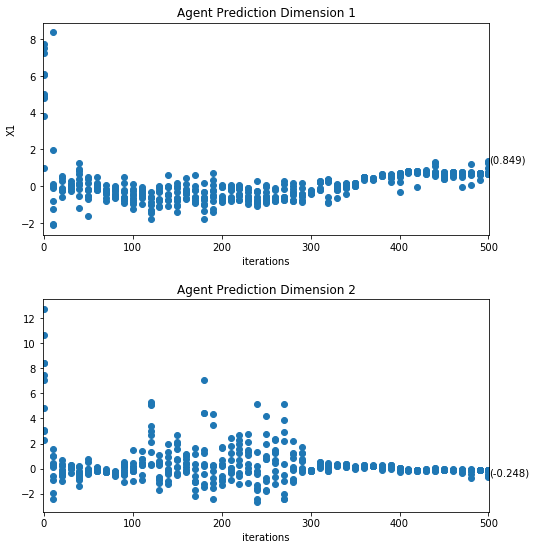

This graph shows the parabolic function and how agent moves after it is well trained.

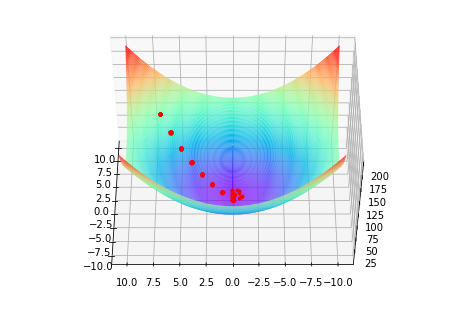

The second example is more complicated Michalewicz function. We have already seen that vanilla TRPO will be fooled and find out a local minimum (1.117, 1.004) as the global minimum. However, TRPO with prioritized experience will find out the true global minimum. This graph shows the convergence of TRPO with prioritized experience:

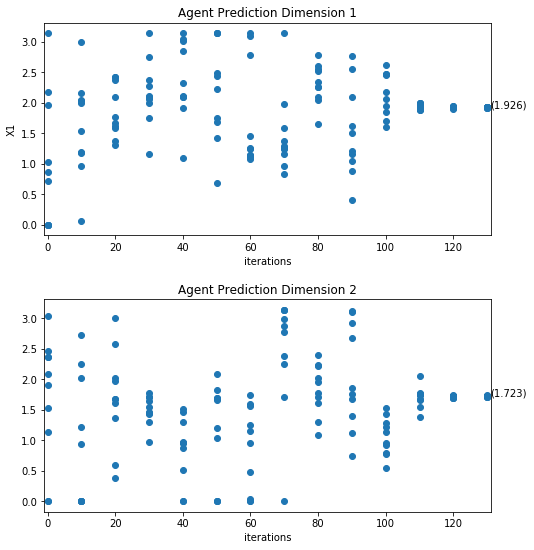

This graph shows the Michalewicz function and how agent moves after it is well trained.

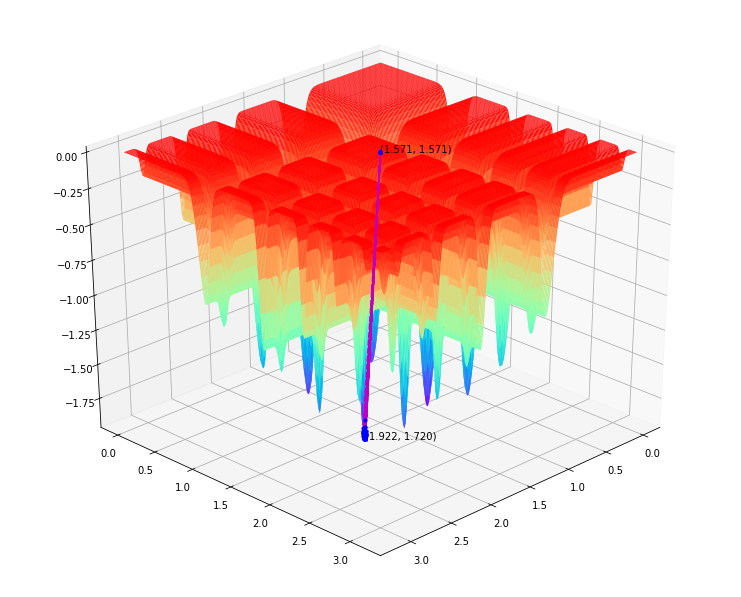

As you can see, agent sucessfully find the true global minimum around (1.93, 1.72)
## Final Thoughts
In this project, we implement a zero-order function optimizer. The original idea comes from very basic random walk algorithm. This is a sampling based algorithm, however, suffering from not utilizing sampled data very effectively. To improve it, we used an agent trained by TRPO replacing the random agent. TRPO is a effective policy optimization algorithm that is widely used in reinforcement learning. However, we discovered that the vanilla TRPO will be fooled by the local minimum. To overcome this drawback, increasing monte carlo sampling size is necessary. However, too largely batch-sized data will significantly increase computation time. Therefore, prioritized sampling those data is an efficient way to reduce data size while ensure global minimum is presented to our agent. With assistance from prioritized experience, TRPO finally trained our gent to correctly locate the true global minimum.

Of course other zero-order algorithms exist. The goal of this project is, however, demonstrating that reinforcement learning principle will certainly be efficient and useful for optimization problem. In fact, there are already wide discusses about learning to learn. It is proved to be a promising topic in deep learning research community.